In [1]:
from typing import Iterator
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
from torch.nn import BCELoss, Parameter


from automatic_diff_engine.tensor import Tensor
from loss.binary_cross_entropy import binary_cross_entropy

x = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [0, 1, 1, 0]
epochs = 1000


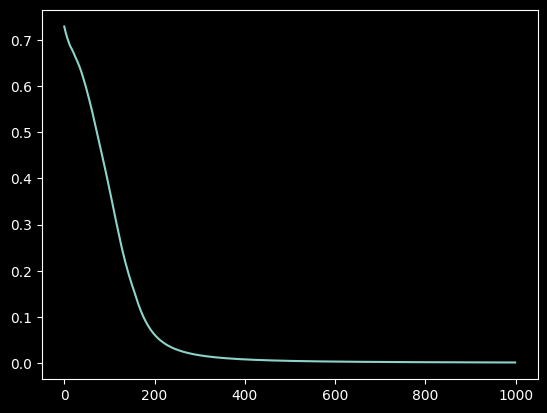

[[1.44398176e-03]
 [9.99149880e-01]
 [9.99036606e-01]
 [9.26988144e-04]]


In [2]:
from torch.optim import Adam
class OfficialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = torch.nn.Linear(2, 8, dtype=torch.double)
        self.hidden2 = torch.nn.Linear(8, 1, dtype=torch.double)
        self.activation = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return x


model = OfficialModel()
loss_fn = BCELoss()
optimizer = Adam(model.parameters(), lr = 0.01)
losses = []

for epoch in range(epochs):
    x_tensor = torch.tensor(x, dtype=torch.double)
    y_tensor = torch.tensor(y, dtype=torch.double)
    optimizer.zero_grad()

    y_hat = model(x_tensor).squeeze()
    loss = loss_fn(y_hat, y_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

plt.plot(losses)
plt.show()

print(model(torch.tensor(x, dtype=torch.double)).detach().numpy())

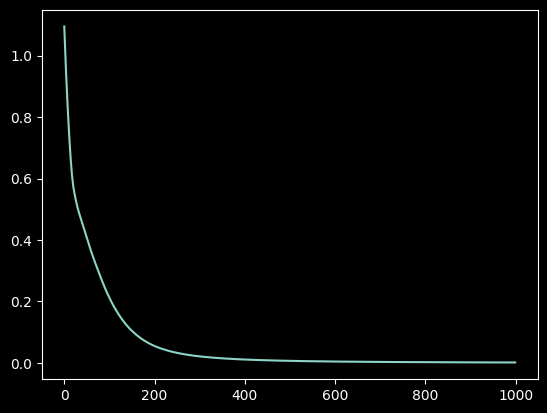

[[0.00222673]
 [0.99831103]
 [0.99890548]
 [0.00125684]]


In [12]:
from optimizer.adam import Adam
from automatic_diff_engine.tensor import Tensor
import numpy as np
from loss.binary_cross_entropy import binary_cross_entropy

class CustomLinear:
    def __init__(self, input_size, output_size):
        super().__init__()

        std = np.sqrt(2.0 / input_size)
        self.weights = Tensor(np.random.randn(input_size, output_size) * std)
        self.bias = Tensor(np.zeros(output_size))

    def forward(self, x: Tensor):
        return x @ self.weights + self.bias

    def parameters(self):
        return [self.weights, self.bias]

class CustomRelu:
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return x.relu()

class CustomSigmoid:
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return x.sigmoid()

class CustomModel:
    def __init__(self):
        super().__init__()
        self.hidden1 = CustomLinear(2, 8)
        self.hidden2 = CustomLinear(8, 1)
        self.relu = CustomRelu()
        self.sigmoid = CustomSigmoid()

    def forward(self, x: Tensor):
        x = self.relu.forward(self.hidden1.forward(x))
        x = self.sigmoid.forward(self.hidden2.forward(x))

        return x

    def parameters(self):
        return self.hidden1.parameters() + self.hidden2.parameters()

model = CustomModel()
loss_fn = binary_cross_entropy
optimizer = Adam(model.parameters(), learning_rate = 0.01)
losses = []

for epoch in range(epochs):
    x_tensor = Tensor(x, requires_grad=False)
    y_tensor = Tensor(y, requires_grad=False)
    optimizer.zero_grad()

    y_hat = model.forward(x_tensor)
    y_hat = y_hat.reshape(y_tensor.shape)
    loss = loss_fn(y_tensor, y_hat)
    loss.backward()

    optimizer.step()

    losses.append(loss.value)

plt.plot(losses)
plt.show()

print(model.forward(Tensor(x)).value)

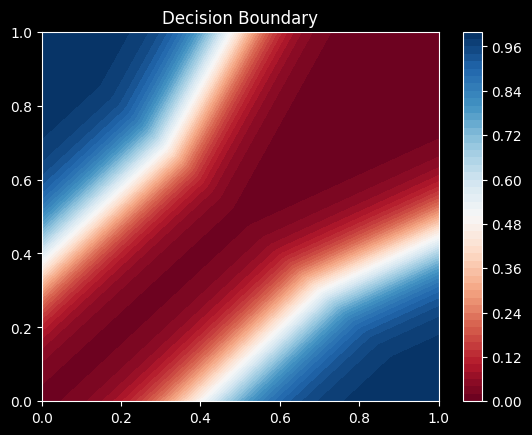

In [11]:
import matplotlib.pyplot as plt

# Create a grid of points
x_range = np.linspace(0, 1, 100)
y_range = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x_range, y_range)
grid = np.c_[xx.ravel(), yy.ravel()]

# Get predictions from your custom model
preds = model.forward(Tensor(grid)).value
preds = preds.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, preds, levels=50, cmap='RdBu')
plt.colorbar()
plt.title("Decision Boundary")
plt.show()